# Demo

### This is an example usage of Graph Edit Distance on brain graphs

Necessary imports

In [1]:
import os
import numpy as np
import scipy.io as sio
import nilearn.plotting as niplt
import matplotlib.pyplot as plt
%matplotlib inline

import align
import read
from graph import BrainGraph
from parcellation import Parcellation
from ged import ged_constrained

/usr/local/lib/python2.7/dist-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


Function to obtain a network representation of a subject's brain connectivity

In [2]:
def get_network(subject, conn_path, parcel_path):
    """
    Get the connectivity network corresponding to the parcellation in parcel_path and the connectivity in
    conn_path file
    """ 
    
    parcel = Parcellation(subject)
    parcel.load(parcel_path)
    
    graph = BrainGraph(subject)
    graph.set_parcellation(parcel)
    
    graph.from_file(conn_path)
    graph.conn_threshold(0.0)
    graph.to_networkx()
    
    return graph.netx

Visualisation function

In [3]:
def plot_connectome(node_coords, edges, title):
    """ Visualise the connectome """
    node_colors = plt.cm.Set1(np.linspace(0, 1, edges.shape[0]))
    
    # Make sure that the adjacency matrix is symmetric
    edges = (edges + edges.T) / 2

    fig, ax = plt.subplots(figsize=(10, 5))
    niplt.plot_connectome(edges, node_coords, title=title, 
                          node_color=node_colors, edge_cmap=plt.cm.Greys,
                          edge_threshold='95%', node_size=150, figure=fig,axes=ax)

Obtain the connectivity matrices and get pair distance

In [4]:
folder_path = '/vol/dhcp-hcp-data/twins_data'
net_folder = 'processed/networks/functional'
pattern = 'KMEANS_ALPHA75_N50'
session = 'S1'
ids = ['195445', '151425']

### Visualise the resulting correspondences

Plot original graphs for pair of subjects

/usr/local/lib/python2.7/dist-packages/nilearn/plotting/displays.py:1259: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if node_color == 'auto':
/usr/lib/pymodules/python2.7/matplotlib/collections.py:548: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == 'face':


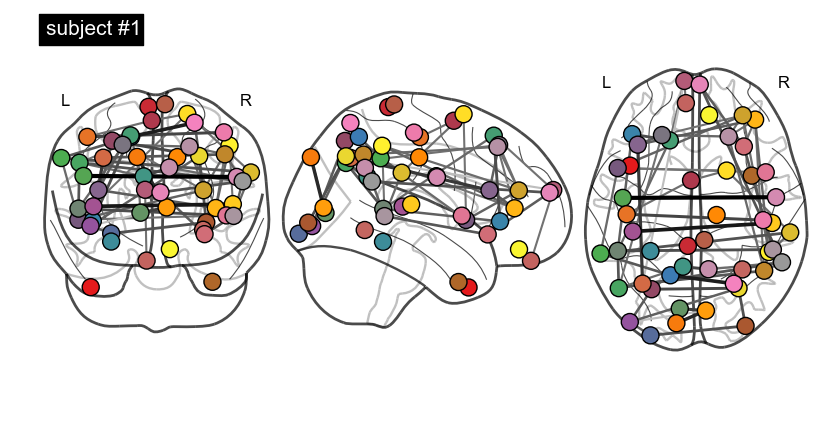

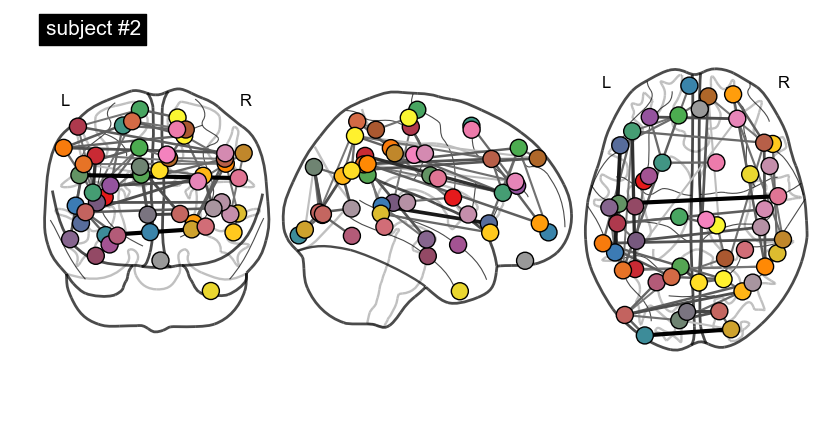

In [5]:
# Parcellation and connectivity file for subject 1
parc1 = os.path.join(folder_path, ids[0], net_folder, ids[0] + '_' + pattern + '_' + session + '_NODES.mat')
conn1 = os.path.join(folder_path, ids[0], net_folder, ids[0] + '_PCORR_' + pattern + '_' + session + '.mat')

nodes1 = sio.loadmat(parc1)['midth_coords']
edges1 = sio.loadmat(conn1)['connectivity']
plot_connectome(nodes1, edges1, 'subject #1')

# Parcellation and connectivity file for subject 2
parc2 = os.path.join(folder_path, ids[1], net_folder, ids[1] + '_' + pattern + '_' + session + '_NODES.mat')
conn2 = os.path.join(folder_path, ids[1], net_folder, ids[1] + '_PCORR_' + pattern + '_' + session + '.mat')

nodes2 = sio.loadmat(parc2)['midth_coords']
edges2 = sio.loadmat(conn2)['connectivity']
plot_connectome(nodes2, edges2, 'subject #2')

Obtain correspondences with matrix alignment based on simulated annealing

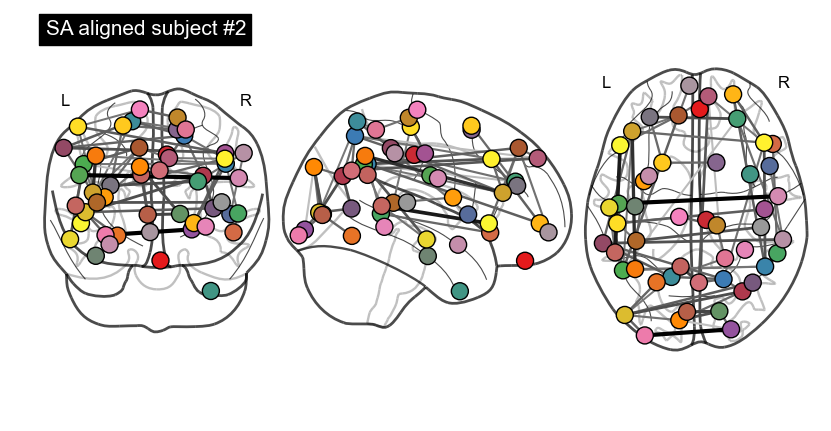

In [6]:
M1 = np.array(edges1)
M1[M1<0] =0
M2 = np.array(edges2)
M2[M2<0] =0

cost, Mind = align.random_align(M1, M2, 'absdff', 100)
plot_connectome(nodes2[Mind], edges2[Mind][:, Mind], 'SA aligned subject #2')

Obtain correspondences with constrained graph edit distance

[17 11  9 21  0  8 22 19 20 13  5 23 24 14 16  6 18 10  3  4 12  7  1  2 15
 26 39 38 47 37 43 49 27 35 44 25 32 34 31 48 28 46 45 30 36 41 40 42 33 29]


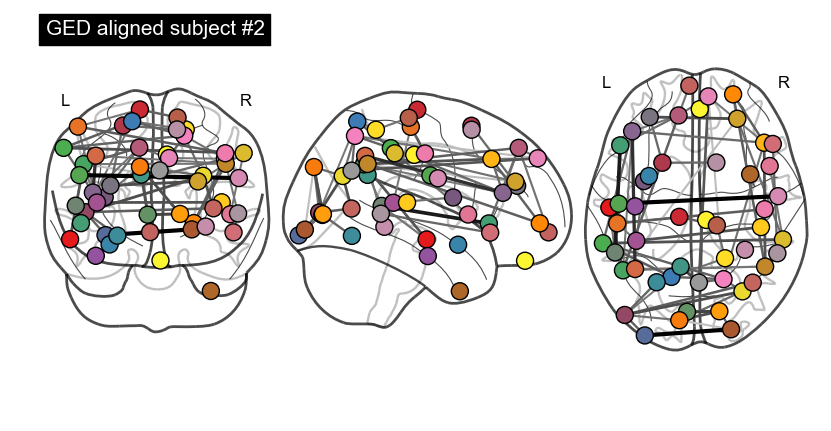

In [7]:
net1 = get_network(ids[0], conn1, parc1)
net2 = get_network(ids[1], conn2, parc2)

ged_obj = ged_constrained.GedConstrained(net1, net2)
dist = ged_obj.norm_distance()
gedInd = ged_obj.Mindices

plot_connectome(nodes2[gedInd], edges2[gedInd][:, gedInd], 'GED aligned subject #2')